# Reverse inference - Example without using ontologies

In [148]:
import warnings
warnings.filterwarnings('ignore')

import stats_helper, datasets_helper
from neurolang.frontend.probabilistic_frontend import ProbabilisticFrontend
from rdflib import RDFS
from nilearn import plotting
import numpy as np
from matplotlib import pyplot as plt
from typing import Iterable
from neurolang import frontend as fe

In [149]:
nl = fe.NeurolangDL()
datasets_helper.load_reverse_inference_dataset_deterministic(nl)

In [150]:
@nl.add_symbol
def agg_count(x: Iterable) -> int:
    return len(x)

@nl.add_symbol
def agg_sum(x: Iterable) -> float:
    return x.sum()

@nl.add_symbol
def agg_mean(x: Iterable) -> float:
    return x.mean()

### Testing julich atlas

In [151]:
with nl.scope as e:
    
    e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z] = (
        e.xyz_julich[e.x, e.y, e.z, e.julich_id] &
        e.xyz_neurosynth[e.x, e.y, e.z, e.id_neurosynth]
    )
    
    e.region_voxels[e.name, e.id_neurosynth, e.x, e.y, e.z] = (
        e.julich_id[e.name, e.julich_id] &
        e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.julich_id[e.name, e.id] = (
        e.julich_ontology[e.name, 'labelIndex', e.id]
    )
    
    e.julich_voxels[e.id_neurosynth, e.x, e.y, e.z] = (
        e.region_voxels['Area Ia (Insula)', e.id_neurosynth, e.x, e.y, e.z]
    )
    
    
    nl_results = nl.solve_all()

In [152]:
def create_region(x, y, z, img):
    voxels = nib.affines.apply_affine(
        np.linalg.inv(img.affine), np.c_[x, y, z]
    )
    return fe.ExplicitVBR(voxels, img.affine, image_dim=img.shape)

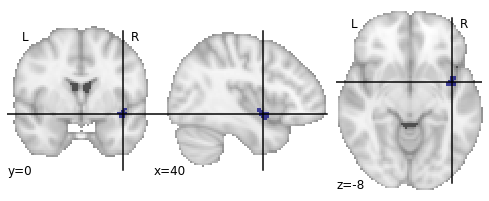

In [153]:
from neurolang.regions import region_union
import nibabel as nib
from nilearn import image

results = nl_results['julich_voxels'].unwrapped_iter()

nsh = fe.neurosynth_utils.NeuroSynthHandler()
ns_ds = nsh.ns_load_dataset()
it = ns_ds.image_table

regions = []
vox_prob = []

atlas_r_filename = './22/MPM/JulichBrain_MPMAtlas_r_N10_nlin2Stdicbm152asym2009c_publicDOI_14622b49a715338ce96e96611d395646.nii.gz'
img_r = image.load_img(atlas_r_filename)
julich_to_ns_mni = image.resample_to_img(
    img_r, it.masker.volume, interpolation="nearest"
)

for id_, x, y, z in results:
    r_overlay = create_region(x, y, z, julich_to_ns_mni)
    vox_prob.append((r_overlay.voxels, 1))
    regions.append(r_overlay)

regions = region_union(regions)

prob_img = nib.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=regions.affine
)
for v, p in vox_prob:
    prob_img.dataobj[tuple(v.T)] = p

#plotting.plot_stat_map(
#    prob_img, 
    #title='Tag "auditory" (Neurolang)', 
    #bg_img='/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/resources/MNI152_T1_2mm_brain.nii.gz',
#    cmap='PuBuGn',
#    display_mode='x',
#    cut_coords=np.linspace(-63, 63, 4),
#)


plotting.plot_roi(prob_img)


### Example

In [154]:
with nl.scope as e:
    e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z] = (
        e.xyz_julich[e.x, e.y, e.z, e.julich_id] &
        e.xyz_neurosynth[e.x, e.y, e.z, e.id_neurosynth]
    )
    
    e.region_voxels[e.name, e.id_neurosynth, e.x, e.y, e.z] = (
        e.julich_id[e.name, e.julich_id] &
        e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.julich_id[e.name, e.id] = (
        e.julich_ontology[e.name, 'labelIndex', e.id]
    )
    
    #e.julich_id[e.name, e.id] = (
    #    e.julich_ontology[e.name, 'subClassOf', e.son_name] &
    #    e.julich_id[e.son_name, e.id]
    #)
    
    e.julich_voxels[e.id_neurosynth, e.x, e.y, e.z] = (
        e.region_voxels['Area Ia (Insula)', e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.term_docs[e.term, e.pmid] = (
        e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        (e.tfidf > 1e-3)        
    )

    e.term_counts[e.term, agg_count(e.pmid)] =  (
        e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        e.term_docs[e.term, e.pmid]
    )
    e.act_counts[e.voxid, agg_count(e.pmid)] = e.ns_activations_by_id[e.pmid, e.voxid]
    
    e.quantity_docs[agg_count(e.pmid)] = e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf]
    
    e.act_prob[e.voxid, e.prob] = (
        e.act_counts[e.voxid, e.count] &
        e.quantity_docs[e.q] &
        (e.prob == e.count / e.q)
    )
    
    nl_results = nl.solve_all()

In [155]:
t = nl_results['julich_voxels'].as_numpy_array()
f = [(int(voxid), x, y, z) for voxid, x, y, z in t]
julich_voxels = nl.add_tuple_set(tuple(f), name='julich_voxels');

t = nl_results['term_docs'].as_numpy_array()
f = [(term, pmid) for term, pmid in t]
term_docs = nl.add_tuple_set(tuple(f), name='term_docs');

t = nl_results['act_counts'].as_numpy_array()
f = [(int(voxid), count) for voxid, count in t]
act_counts = nl.add_tuple_set(tuple(f), name='act_counts');

t = nl_results['act_prob'].as_numpy_array()
f = [(int(voxid), p) for voxid, p in t]
act_prob = nl.add_tuple_set(tuple(f), name='act_prob');


In [156]:
with nl.scope as e:
    
    e.act_term_counts[e.voxid, e.term, agg_count(e.pmid)] = (
        julich_voxels[e.voxid, e.x, e.y, e.z] &
        term_docs[e.term, e.pmid] &
        e.ns_activations_by_id[e.pmid, e.voxid]
    )

    e.p_term_given_act[e.term, e.voxid, e.prob] = (
        e.act_term_counts[e.voxid, e.term, e.act_term_count] &
        act_counts[e.voxid, e.act_count] &
        (e.prob == e.act_term_count / e.act_count)
    )
    
    e.e_term_given_aud_act[e.term, agg_sum(e.p)] = (
        e.p_term_given_act[e.term, e.voxid, e.prob] & 
        act_prob[e.voxid, e.act_prob_] &
        (e.p == e.prob * e.act_prob_)    
    )
    
    nl_results = nl.solve_all()

In [157]:
c = nl_results['e_term_given_aud_act']._container.copy()

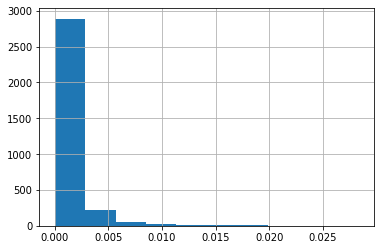

In [158]:
c[1].hist();

In [159]:
c[c[1] >= c[1].quantile(.99)].sort_values(1, ascending=False)

,0,1
1689,magnetic,0.028377
2501,resonance,0.028316
1690,magnetic resonance,0.028125
1214,functional magnetic,0.025766
3078,using,0.023658
1314,healthy,0.022975
194,anterior,0.022636
1492,insula,0.020688
420,cingulate,0.019739
2917,task,0.018969


# Reverse inference - Example using ontologies

In [160]:
import warnings
warnings.filterwarnings('ignore')

import stats_helper, datasets_helper
from neurolang.frontend.probabilistic_frontend import ProbabilisticFrontend
from rdflib import RDFS, RDF
from nilearn import plotting
import numpy as np
from matplotlib import pyplot as plt
from typing import Iterable
from neurolang import frontend as fe

nl = fe.probabilistic_frontend.ProbabilisticFrontend()

datasets_helper.load_reverse_inference_dataset_deterministic(nl)

paths = 'neurolang_data/ontologies/cogat.xrdf'
nl.load_ontology(paths)


@nl.add_symbol
def agg_count(x: Iterable) -> int:
    return len(x)

@nl.add_symbol
def agg_sum(x: Iterable) -> float:
    return x.sum()

@nl.add_symbol
def agg_mean(x: Iterable) -> float:
    return x.mean()

@nl.add_symbol
def first_word(name: str) -> str:
    return name.split(" ")[0].lower()

In [84]:
part_of = nl.new_symbol(name='http://www.obofoundry.org/ro/ro.owl#part_of')
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))
label = nl.new_symbol(name=str(RDFS.label))

In [85]:
#triples = nl.symbol_table[nl.get_ontology_triples_symbol().name]
#a = triples.value.as_numpy_array()
#t = [('Auditory', str(RDF.type), 'http://www.cognitiveatlas.org/ontology/cogat.owl#CAO_00148')]

#t = np.concatenate((a, t))
#nl.add_extensional_predicate_from_tuples(t, name=nl.get_ontology_triples_symbol().name)

In [161]:
with nl.scope as e:
    e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z] = (
        e.xyz_julich[e.x, e.y, e.z, e.julich_id] &
        e.xyz_neurosynth[e.x, e.y, e.z, e.id_neurosynth]
    )
    
    e.region_voxels[e.name, e.id_neurosynth, e.x, e.y, e.z] = (
        e.julich_id[e.name, e.julich_id] &
        e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.julich_id[e.name, e.id] = (
        e.julich_ontology[e.name, 'labelIndex', e.id]
    )
    
    #e.julich_id[e.name, e.id] = (
    #    e.julich_ontology[e.name, 'subClassOf', e.son_name] &
    #    e.julich_id[e.son_name, e.id]
    #)
    
    e.julich_voxels[e.id_neurosynth, e.x, e.y, e.z] = (
        e.region_voxels['Area Ia (Insula)', e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.term_docs[e.term, e.pmid] = (
        e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        (e.tfidf > 1e-3)        
    )

    e.term_counts[e.term, agg_count(e.pmid)] =  (
        e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        e.term_docs[e.term, e.pmid]
    )
    
    e.act_counts[e.voxid, agg_count(e.pmid)] = e.ns_activations_by_id[e.pmid, e.voxid]
    
    e.quantity_docs[agg_count(e.pmid)] = e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf]
    
    e.act_prob[e.voxid, e.prob] = (
        e.act_counts[e.voxid, e.count] &
        e.quantity_docs[e.q] &
        (e.prob == e.count / e.q)
    )
    
    nl_results = nl.solve_all()

In [162]:
t = nl_results['julich_voxels'].as_numpy_array()
f = [(int(voxid), x, y, z) for voxid, x, y, z in t]
julich_voxels = nl.add_tuple_set(tuple(f), name='julich_voxels');

t = nl_results['term_docs'].as_numpy_array()
f = [(term, pmid) for term, pmid in t]
term_docs = nl.add_tuple_set(tuple(f), name='term_docs');

t = nl_results['act_counts'].as_numpy_array()
f = [(int(voxid), count) for voxid, count in t]
act_counts = nl.add_tuple_set(tuple(f), name='act_counts');

t = nl_results['act_prob'].as_numpy_array()
f = [(int(voxid), p) for voxid, p in t]
act_prob = nl.add_tuple_set(tuple(f), name='act_prob');

In [163]:
from neurolang.expressions import Constant, Symbol

@nl.add_symbol
def words(x: Iterable) -> str:
    b = ''
    for a in x:
        b = b + a + ' '
        
    b = set(b.lower().split(' '))
    
    return " ".join(b)

@nl.add_symbol
def is_in(x: str, l: str) -> str:
    b = l.split(' ')
    if x in b:
        return True
    
    return False
    



In [164]:
hasTopConcept = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#hasTopConcept')
with nl.scope as e:
    e.pre_part[e.x, e.y] = part_of[e.x, e.y]

    #e.ontology_terms[e.term] = (
    #    e.pre_part["Auditory", e.y] & subclass_of[e.z, e.y] & label(e.z, e.n) &
    #    (e.term == nl.symbols.first_word(e.n))
    #)
    
    e.ontology_terms[e.words(e.name)] = (
        hasTopConcept[e.uri, 'Executive-Cognitive Control'] &
        label[e.uri, e.name]
    )
    
    e.act_term_counts[e.voxid, e.term, agg_count(e.pmid)] = (
        julich_voxels[e.voxid, e.x, e.y, e.z] &
        term_docs[e.term, e.pmid] &
        e.ns_activations_by_id[e.pmid, e.voxid]
    )

    e.p_term_given_act[e.term, e.voxid, e.prob] = (
        e.act_term_counts[e.voxid, e.term, e.act_term_count] &
        act_counts[e.voxid, e.act_count] &
        (e.prob == e.act_term_count / e.act_count)
    )
    
    e.e_term_given_aud_act[e.term, agg_sum(e.p)] = (
        e.p_term_given_act[e.term, e.voxid, e.prob] & 
        act_prob[e.voxid, e.act_prob_] &
        (e.p == e.prob * e.act_prob_)    
    )
    
    nl_results = nl.solve_all()

Cognitive control
Semantic working memory
Maintenance
Goal state
Central executive
Goal
Proactive control
Cognitive load
Response conflict
Metamemory
Manipulation
Supervisory attentional system
Performance monitoring
Interference resolution
Response inhibition
Self monitoring
Goal maintenance
Set shifting
Goal formation
Planning
Inhibition of return
Updating
Chunking
Resistance to distractor inference
Top down processing
Phonological working memory
Goal management
Inhibition
Task set
Working memory maintenance
Selective control
Behavioral inhibition (cognitive)
Active maintenance
Error detection
Working memory retrieval
Task switching
Self control
Working memory storage
Resource limit
Monitoring
Visuospatial sketch pad
Working memory
Cognitive control
Semantic working memory
Maintenance
Goal state
Central executive
Goal
Proactive control
Cognitive load
Response conflict
Metamemory
Manipulation
Supervisory attentional system
Performance monitoring
Interference resolution
Response inhibi

In [165]:
t = nl_results['ontology_terms'].as_numpy_array()
f = [tuple(term) for term in t]
julich_voxels = nl.add_tuple_set(tuple(f), name='ontology_terms');

t = nl_results['e_term_given_aud_act'].as_numpy_array()
f = [(term, p) for term, p in t]
julich_voxels = nl.add_tuple_set(tuple(f), name='reverse_inference');

In [166]:

#with nl.scope as e:
#    e.filtered_terms[e.term, e.p] = (
#        e.reverse_inference[e.term, e.p] &
#        e.ontology_terms[e.term]
#    )
    
    

with nl.scope as e:
    e.res[e.term, e.p] = (
        e.ontology_terms[e.t] & 
        e.reverse_inference[e.term, e.p] &
        is_in[e.term, e.t]
    )
    
    nl_results = nl.solve_all()

In [167]:
c = nl_results['res']._container.copy()
c.sort_values(1, ascending=False)

,0,1
2917,task,0.023711
2517,response,0.021610
591,control,0.020747
447,cognitive,0.016973
1773,memory,0.011451
2135,performance,0.011012
305,behavioral,0.010960
2782,state,0.010659
2614,self,0.007405
388,central,0.006709


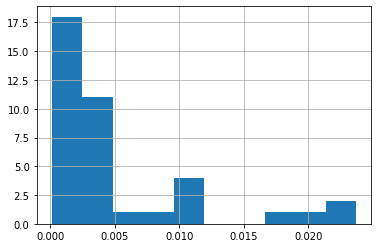

In [168]:
c[1].hist();

In [169]:
c[c[1] >= c[1].quantile(.99)].sort_values(1, ascending=False)

,0,1
2917,task,0.023711


In [40]:
import rdflib

g = rdflib.Graph()
g.load('neurolang_data/ontologies/cogat.xrdf')

In [147]:
control = g.triples((None, rdflib.term.URIRef('http://www.w3.org/2004/02/skos/core#hasTopConcept'), rdflib.term.Literal('Executive-Cognitive Control')))
for a, b, c in control:
    n = list(g.triples((a, rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#label'), None)))
    print(n[0][2])

Behavioral inhibition (cognitive)
Proactive control
Goal maintenance
Top down processing
Working memory retrieval
Chunking
Selective control
Response inhibition
Goal management
Working memory
Working memory storage
Performance monitoring
Semantic working memory
Updating
Set shifting
Interference resolution
Task set
Goal state
Inhibition
Planning
Resource limit
Task switching
Maintenance
Central executive
Response conflict
Cognitive control
Metamemory
Resistance to distractor inference
Goal
Self monitoring
Manipulation
Error detection
Goal formation
Supervisory attentional system
Working memory maintenance
Self control
Active maintenance
Cognitive load
Phonological working memory
Visuospatial sketch pad
Monitoring
Inhibition of return
